In [2]:
import scipy.io
import os
import sys
sys.path.insert(0,'..')
from rnn.model import RNN
from rnn.task import trial_generator
import numpy as np
from analysis.tf_utils import *
from analysis.analysis_utils import *
from scipy.stats import zscore
from itertools import permutations
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
# from parula import Parula
from cycler import cycler
from analysis.summary import run_summary
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import pickle
%matplotlib inline

# Experiment settings

In [3]:
base_dir = ""
task_dir = "datasweep_main.pkl"

summary_settings = {
    "upsample" : 1, # Increase temporal resolution
    "ref_phase" : "sine", # Reference phase for 'spike-phase' histogram, either sine or LFP
    "onlyGaba" : False,  # Only use inhibitory neurons for calculating LFP
    "cutoff_p": 10e-3, # For Wilc p test
    "normalize_fr_extract":  True,  # Normalize extracted firing rates
    "n_trials": 224,  # Number trials used in analysis
    "randomize_onset": False, # Randomise stimulus onset
    "delay_ms": 2500, # Delay time in ms
    "disable_noise": False, # With or without noise
    "freqs_l": np.logspace(*np.log10([1, 25]), num=50), # Frequencies for spectrograms
    "balance_trials": True, # Draw trials with balanced proportion of each stimuli
    "substr_mean_LFP": False, # Substract mean LFP
    "delay_buffer1": 25, # Disregard short period after stimulus offset
    "delay_buffer2": 25, # Disregard short period before probe onset
    "nbins": 20, # Number of bins for 'spike' phase histograms
    "common_baseline" : True, # Common baseline
    "freqs": [1, 1.5, 1.75, 2.04, 2.37, 2.75, 3.21, 3.73, 4.35, 5] # Frequencies for vex plots
}
pltcolors, pltcolors_alt = steffiscolours()


# Run or load summary over many models

In [4]:
model_dir = os.path.join(base_dir, "..", "models/sweep_main")
data_dir = "../data/"+str(task_dir)
data_list, summary_settings = run_summary(summary_settings, model_dir, data_dir)


In [5]:
data_list.keys()

dict_keys(['model_names', 'loss_f', 'acc', 'val_acc', 'train_acc', 'pre_spectrum', 'post_spectrum', 'ranked_neurons', 'wilc_ps', 'd_primes', 'vex', 'shvex', 'vex_f', 'phase_order', 'kappas', 'low_vex', 'low_shvex', 'low_kappas', 'summary_settings'])

# Generate plots

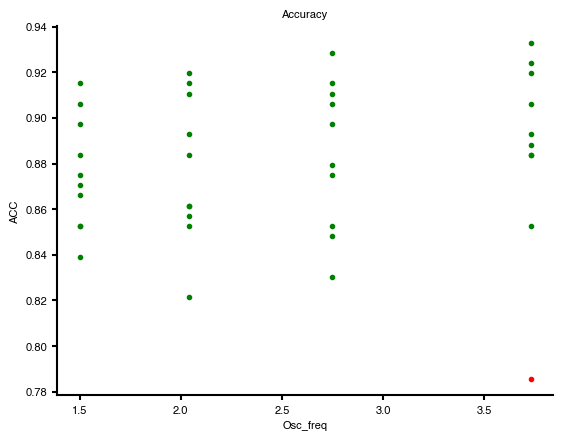

In [12]:
# Plot accuracies of all trained models

acc_threshold = 0.80
acc_indices = []
for i in range(len(data_list["acc"])):
    if data_list["acc"][i]>acc_threshold:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'green')
        acc_indices.append(i)
    else:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'red')

plt.xlabel("Osc_freq")
plt.ylabel("ACC")
plt.title("Accuracy");

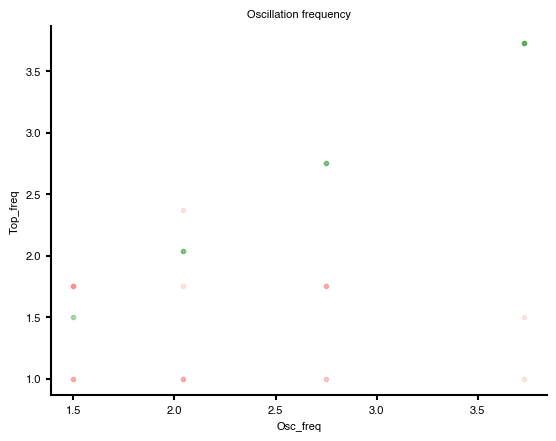

In [13]:
# Plot oscillation frequency for all trained models

fr_l = data_list["summary_settings"]["freqs_l"]
plt_indices = []
for i in acc_indices:
    #osc_freq = fr_l[np.argmax(np.mean(data_list["post_spectrum"][i],axis=1))]
    osc_freq = data_list['vex_f'][i]

    if np.isclose(data_list["loss_f"][i], osc_freq, atol=.2):
        plt.scatter(data_list["loss_f"][i],osc_freq, color= 'green', alpha = 0.1)
        plt_indices.append(i)

    else:
        plt.scatter(data_list["loss_f"][i], osc_freq, color = 'red', alpha = 0.1)
plt.xlabel("Osc_freq")
plt.ylabel("Top_freq")
plt.title("Oscillation frequency");


In [14]:
data_list['model_names'][0]

'k56ppwz0SpecRad1.5DaleTrueTC20_100rand0sparse1osc2.75cost0.1'

In [15]:
accs_over_models = [[],[],[],[]]
#freqs=[1.5,2.04,2.75,3.73]
freqs=[2.75]

num_mod=0
for freq_i, freq in enumerate(freqs):
    for ind in plt_indices:
        fname = data_list['model_names'][ind]
        model_file = os.path.join(model_dir, fname)
        net = RNN()
        var = scipy.io.loadmat(model_file)
        if np.isclose(var['lossF'][0][0],freq):
            net.load_model(model_file)
            model_par, settings = reinstate_params(var)

            #trial generator
            trial_gen = trial_generator(
                int(var["n_items"][0][0]),
                net.n_channels,
                net.out_channels,
                val_perc=0,
            )

            delays = np.arange(150,400,1)
            accs = extrapolate_delays(128,delays,settings,trial_gen,net,verbose=False)
            accs_over_models[freq_i].append(accs)
            print(str(num_mod) + "/" +str(len(plt_indices)))
            num_mod+=1

Num GPUs Available:  0
Num GPUs Available:  0
balanced trials converged


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (250,) and (0,)

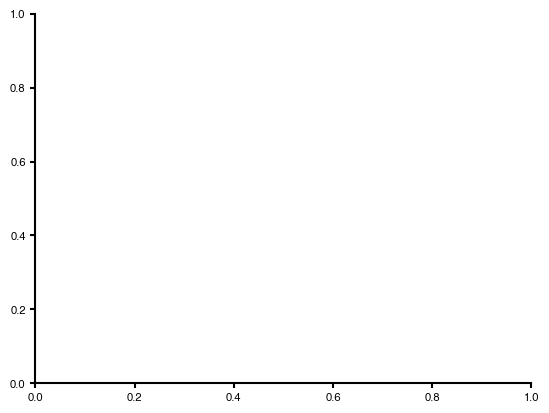

In [16]:
for i in range(4):
    plt.plot(delays,np.array(accs_over_models[i]).T+i,color=pltcolors_alt[i])
    plt.plot(delays,np.mean(np.array(accs_over_models[i]),axis=0).T+i,color='black')

    print(len(accs_over_models[i]))
plt.xlabel("delay")
plt.ylabel("accuracy")

In [17]:
#np.save("accs28.npy",np.array(accs_over_models[0]))

0
0
0
0


Text(0, 0.5, 'accuracy')

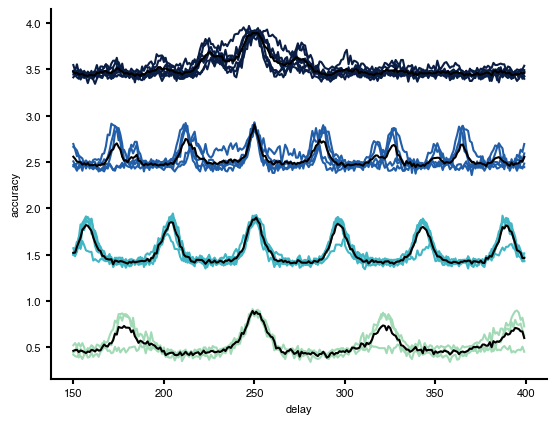

In [18]:
data =["accs15.npy","accs20.npy","accs27.npy","accs37.npy"]
for i in range(4):
    dat = np.load(data[i])
    plt.plot(delays,dat.T+i,color=pltcolors_alt[i])
    plt.plot(delays,np.mean(dat,axis=0).T+i,color='black')

    print(len(accs_over_models[i]))
plt.xlabel("delay")
plt.ylabel("accuracy")

In [19]:
import matplotlib.pyplot as plt

3
0
5
0
5
0
7
0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


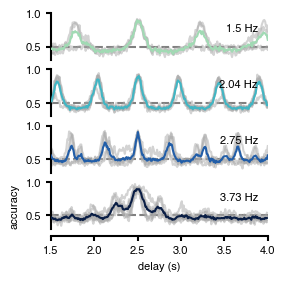

In [20]:
data =["accs15.npy","accs20.npy","accs27.npy","accs37.npy"]
freqs=[1.5,2.04,2.75,3.73]
fig,axs = plt.subplots(4,figsize=(2.8,2.8))
lwm=.5
for i in range(4):
    dat = np.load(data[i])
    print(len(dat))
    axs[i].plot(delays/100,dat.T,color='darkgrey',alpha=.5)
    axs[i].plot(delays/100,np.mean(dat,axis=0).T,color=pltcolors_alt[i],zorder=10)
    axs[i].plot(delays/100,np.mean(dat,axis=0).T,color=pltcolors_alt[i],zorder=10,alpha=0,label=str(freqs[i]) + " Hz",lw = lwm)

    axs[i].axhline(0.5,color='grey',zorder=-10,ls='--')
    axs[i].set_ylim(0.3,1)
    axs[i].set_xlim(delays[0]/100,delays[-1]/100)
    axs[i].spines['bottom'].set_position(('outward',5)) 
    #axs[i].spines['left'].set_position(('outward', 3)) 
    if i<3:
        axs[i].spines["bottom"].set_visible(False)
        axs[i].set_xticks([])
    else:
        axs[i].set_xticks(np.arange(1.5,4.01,0.5))

    print(len(accs_over_models[i]))
axs[0].legend(loc=1).set_zorder(102)
axs[1].legend(loc=1).set_zorder(102)
axs[2].legend(loc=1).set_zorder(102)
axs[3].legend(loc=1).set_zorder(102)

plt.xlabel("delay (s)")
plt.ylabel("accuracy")
plt.savefig("../figures/acc.pdf",facecolor='white')

In [10]:
dat.shape

(3, 250)